#   CNN MODEL

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# Read dataset

In [2]:
REBUILD_DATA = False

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "kagglecatsanddogs_3367a/PetImages/Cat"
    DOGS = "kagglecatsanddogs_3367a/PetImages/Dog"
    # TESTING = "PetImages/Testing"
    LABELS = {CATS: 0, DOGS: 1}
    data_set = []

    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.data_set.append([np.array(img), np.eye(2)[self.LABELS[label]]])
                        # do something like print(np.eye(2)[1]), just makes one_hot
                        #print(np.eye(2)[self.LABELS[label]])

                        if label == self.CATS:
                            self.catcount += 1
                        elif label == self.DOGS:
                            self.dogcount += 1

                    except Exception as e:
                        pass
                        #print(label, f, str(e))

        np.random.shuffle(self.data_set)
        np.save("Data_set.npy", self.data_set)
        print('Cats:', dogsvcats.catcount)
        print('Dogs:', dogsvcats.dogcount)

if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

# Store dataset

Data_set 24946
[[array([[129, 126, 132, ..., 133, 127,  95],
         [127, 129, 140, ..., 139, 129,  81],
         [131, 142, 149, ..., 139, 140,  58],
         ...,
         [ 83,  75,  74, ...,  90, 116,  96],
         [ 68,  75,  89, ..., 128, 105, 152],
         [145, 160, 166, ..., 184, 105,  93]], dtype=uint8)
  array([1., 0.])]]


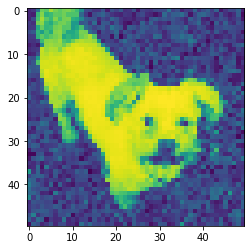

In [10]:
data_set = np.load("Data_set.npy", allow_pickle=True)
print("Data_set",len(data_set))
print(data_set[0:1])
img = data_set[2][0]
import matplotlib.pyplot as plt
imgplot = plt.imshow(img)

# Create Model Function

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Cnn_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50, 50).view(-1, 1, 50, 50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512)  # flattening.
        self.fc2 = nn.Linear(512, 2)  # 512 in, 2 out bc we're doing 2 classes (dog vs cat).

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # bc this is our output layer. No activation here.
        return F.softmax(x, dim=1)


cnn_model_obj = Cnn_model()
print(cnn_model_obj)
# -------------------------------- manual testing ---------


Cnn_model(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


/home/sumit/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# Test our model and check Accuracy

In [5]:
import torch.optim as optim
optimizer = optim.Adam(cnn_model_obj.parameters(), lr=0.001)
loss_function = nn.MSELoss()
X = torch.Tensor([i[0] for i in data_set]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in data_set])
VAL_PCT = 0.1  # lets reserve 10% of our data for validation
val_size = int(len(X)*VAL_PCT)
print(val_size)
train_X = X[:-val_size]
train_y = y[:-val_size]
test_X = X[-val_size:]
test_y = y[-val_size:]
print(len(train_X), len(test_X))
BATCH_SIZE = 100
EPOCHS = 8

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
        #print(f"{i}:{i+BATCH_SIZE}")
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]

        cnn_model_obj.zero_grad()

        outputs = cnn_model_obj (batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    # Does the update

    print(f"Epoch: {epoch}. Loss: {loss}")
torch.save(cnn_model_obj .state_dict(), "Dog_Cat_trained_model.pth")
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = cnn_model_obj (test_X[i].view(-1, 1, 50, 50))[0]  # returns a list,
        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))

2494
22452 2494


100%|█████████████████████████████████████████| 225/225 [02:11<00:00,  1.71it/s]


Epoch: 0. Loss: 0.2056284099817276


100%|█████████████████████████████████████████| 225/225 [02:21<00:00,  1.60it/s]


Epoch: 1. Loss: 0.14274635910987854


100%|█████████████████████████████████████████| 225/225 [02:24<00:00,  1.56it/s]


Epoch: 2. Loss: 0.08317311108112335


100%|█████████████████████████████████████████| 225/225 [02:21<00:00,  1.59it/s]


Epoch: 3. Loss: 0.06843768805265427


100%|█████████████████████████████████████████| 225/225 [02:25<00:00,  1.55it/s]


Epoch: 4. Loss: 0.06149988994002342


100%|█████████████████████████████████████████| 225/225 [02:23<00:00,  1.57it/s]


Epoch: 5. Loss: 0.05524549260735512


100%|█████████████████████████████████████████| 225/225 [02:25<00:00,  1.54it/s]


Epoch: 6. Loss: 0.05285016447305679


100%|█████████████████████████████████████████| 225/225 [02:21<00:00,  1.59it/s]


Epoch: 7. Loss: 0.06403280794620514


100%|██████████████████████████████████████| 2494/2494 [00:08<00:00, 302.52it/s]

Accuracy:  0.729


# model testing

k : tensor([[[[ 16.,   3.,  13.,  ...,  47.,  51.,  49.],
          [ 28.,  26.,  47.,  ...,  54.,  49.,  47.],
          [ 52.,  58.,  69.,  ...,  51.,  47.,  44.],
          ...,
          [130., 109., 221.,  ..., 231., 244., 226.],
          [219., 226., 223.,  ..., 144., 131., 205.],
          [ 85., 207., 167.,  ..., 240., 236., 233.]]]])
net_out tensor([1.0000e+00, 9.0313e-13], grad_fn=<SelectBackward>)
predicted_class tensor(0)


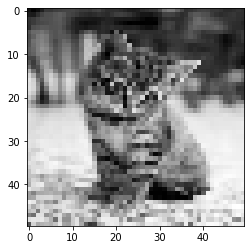

In [11]:
import cv2
import torch
# Model class must be defined somewhere
model = Cnn_model()
model.load_state_dict(torch.load("Dog_Cat_trained_model.pth"))
model.eval()

img = cv2.imread("test/6.jpeg", cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (50,50))
import matplotlib.pyplot as plt
plt.gray()
plt.imshow(img)
k = torch.Tensor(img).view(-1,1,50,50)
print("k :",k)
net_out = model(k)[0]
print ("net_out",net_out)
predicted_class = torch.argmax(net_out)
print("predicted_class",predicted_class)
# LABELS = {CATS: 0, DOGS: 1}


# real_class = torch.argmax(test_y[i])
# net_out = net(test_X[i].view(-1, 1, 50, 50))[0]  # returns a list,
# predicted_class = torch.argmax(net_out)

# if predicted_class == real_class:
#     correct += 1